In [1]:
import reading_plaid_meta as rpm
import numpy as np
import pandas as pd
from glob import glob
import re
import matplotlib.pyplot as plt
import data_augmentation_funcs as aug
import scipy
import os
import soundfile as sf

In [ ]:
#pulling from PLAID

#gets all labels from PLAID
labels = rpm.read_plaid_meta()

#some important parameters
sample_freq = 30000 #original sampling rate
mains_freq = 60
new_sample_freq = 5000 #new sampling frequency
start_buffer_time = 0.05 #the max buffer time before the device switch on (in seconds)
num_rows_start = np.floor(new_sample_freq*start_buffer_time).astype("int") #maximum number of rows allowed before event start
threshold = 1.5 #the minimum threshold to define an event (in Watts)
time_len = 1 #the desired length of each example file (in seconds) after cleaning. Num of data points will then be time_len*new_sample_freq
num_rows_total = np.floor(time_len*new_sample_freq).astype("int") #number of rows allowed in the full file

#numerically sort through files
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts
files = sorted(glob("c:/Users/tslee/IRP Data/PLAID_DATASET/2017/2017/*"), key=numericalSort) #this is the folder that PLAID data is saved to
good_labels = []
extracted_data = []

for i, file in enumerate(files):

    file_data = pd.read_csv(file, header=None, names=("current", "voltage"))
    #calculate apparent power from each file
    data_df=rpm.apparent_power(file_data, sample_freq, mains_freq)
    #downsample data to set sampling frequency
    data_df = rpm.downsample(data_df, sample_freq, new_sample_freq, axis=0)

    #cut off start of recording if it is more than the start_buffer_time
    data_df, is_bad_file = rpm.event_start(data_df, threshold, num_rows_start, num_rows_total)
    #print(i)
    #check if data_df is not a dataframe, meaning that that file is a bad file and has no suitable events
    if not is_bad_file:
        #repeatedly appending to a list is faster than numpy stack type
        good_labels.append(labels.iloc[i].loc["appliance_type"])
        extracted_data.append(data_df[["apparent_power","current","voltage", "rms_current"]].to_numpy()[np.newaxis, :, :])
        
extracted_data = np.vstack(extracted_data)
good_labels = np.asarray(good_labels)

In [9]:
#printing number of each appliance type
print(pd.DataFrame(good_labels, columns=["appliance"])["appliance"].value_counts())

Hairdryer                   243
Microwave                   226
Compact Fluorescent Lamp    216
Air Conditioner             189
Laptop                      154
Fan                         152
Incandescent Light Bulb     143
Heater                       82
Vacuum                       73
Washing Machine              73
Fridge                       66
Name: appliance, dtype: int64


In [11]:
#saving plaid raw curr data and labels
#data_and_labels = np.hstack((good_labels.reshape((-1, 1)), extracted_data[:, :, 1].astype(np.float32)))
AC_curr_data = extracted_data[:, :, 1].astype(np.float32)
RMS_curr_data = extracted_data[:, :, 3].astype(np.float32)
save_path = "C:\\Users\\tslee\\IRP Data\\DMF_Internship\\DATA\\"
#np.save((save_path + "PLAID_5000Hz_AC_data.npy"), AC_curr_data)
np.save((save_path + "PLAID_5000Hz_RMS_data.npy"), RMS_curr_data)
#np.save((save_path + "PLAID_5000Hz_curr_labels.npy"), good_labels)

In [3]:
#loading plaid AC data
save_path = "C:\\Users\\tslee\\IRP Data\\DMF_Internship\\DATA\\"
plaid_AC_data = np.load((save_path + "PLAID_5000Hz_AC_data.npy"), allow_pickle=True)
augmented_data = aug.change_mains_freq(60, 50, plaid_AC_data)
augmented_data = aug.window_shift(augmented_data, 10, sample_freq=5000)
augmented_data = aug.scale(augmented_data)
#saving augmented data
#np.save((save_path + "PLAID_5000Hz_AC_AUGMENTED_data.npy"), augmented_data)

In [28]:
#loading plaid RMS data
save_path = "C:\\Users\\tslee\\IRP Data\\DMF_Internship\\DATA\\"
plaid_RMS_data = np.load((save_path + "PLAID_5000Hz_RMS_data.npy"), allow_pickle=True)
#augmented_data = aug.change_mains_freq(60, 50, plaid_RMS_data) #don't need this for RMS
augmented_data = aug.window_shift(plaid_RMS_data, 10, sample_freq=5000)
augmented_data = aug.scale(augmented_data, num_splits=5)
#saving augmented data
#np.save((save_path + "PLAID_5000Hz_RMS_AUGMENTED_data.npy"), augmented_data)

In [145]:
#test reshaping data:
plaid_rows = augmented_data.shape[0]
for i in augmented_data.shape[2:]:
    plaid_rows *= i
data_reshaped = augmented_data.transpose((3, 2, 0, 1)).reshape((plaid_rows, augmented_data.shape[1]), order="C")

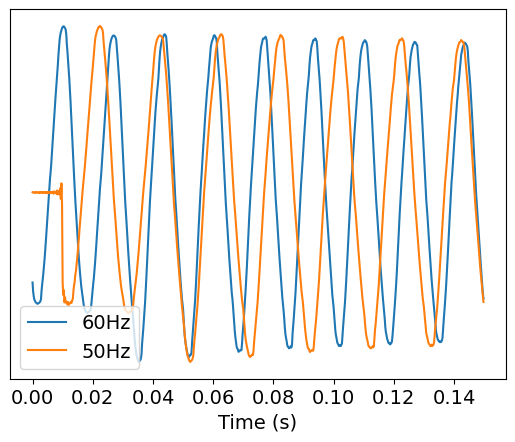

In [22]:
#plotting plaid Augmented data

#plotting comparison of current shifting
plt.plot(np.arange(750)/5000, augmented_data[100, 250:1000, 0, 0, 0], label="60Hz")
plt.plot(np.arange(750)/5000, augmented_data[100, 250:1000, 1, 0, 0], label="50Hz")
plt.yticks(ticks=[])
plt.xticks(fontsize=14)
plt.xlabel("Time (s)", fontsize=14)
plt.legend(fontsize=14)

Text(0.5, 0, 'Time (s)')

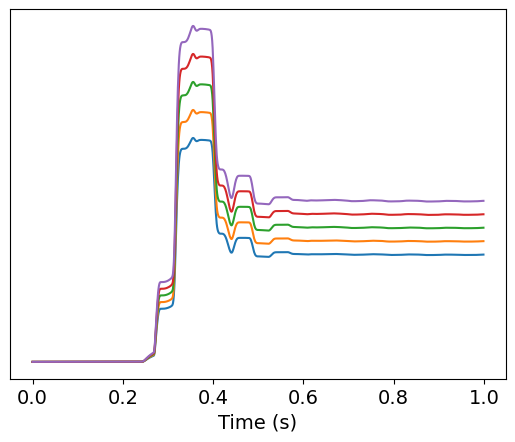

In [34]:
#plotting plaid Augmented data

#plotting comparison of current shifting
plt.plot(np.arange(1000)/1000, augmented_data[200, :1000, 0, :])
#plt.plot(np.arange(5000)/5000, augmented_data[100, :, :, 0], label="50Hz")
plt.yticks(ticks=[])
plt.xticks(fontsize=14)
plt.xlabel("Time (s)", fontsize=14)
#plt.legend(fontsize=14)

In [93]:
#loading in WHITED data

new_samplerate = 5000 #new sampling frequency
start_buffer_time = 0.05 #the max buffer time before the device switch on (in seconds)
num_rows_start = np.floor(new_samplerate*start_buffer_time).astype("int") #maximum number of rows allowed before event start
threshold = 1.5 #the minimum threshold to define an event (in Watts)

#This needs to be more than the min length of 1 second, so that after augmenting the 
# mains freq from 50Hz to 60Hz, there are enough data points to match the 5000 data points in PLAID
time_len = 1.2 #the desired length of each example file (in seconds) after cleaning. Num of data points will then be time_len*new_sample_freq
num_rows_total = np.floor(time_len*new_samplerate).astype("int") #number of rows allowed in the full file

#create dictionaries of current and voltage factors, and mains frequencies
location_dict = {
    "r1": ["Germany", 50],
    "r2": ["Germany", 50],
    "r3": ["Germany", 50],
    "r4": ["Indonesia", 50],
    "r5": ["Indonesia", 50],
    "r6": ["Austria", 50],
    "r7": ["Germany", 50],
    "r8": ["Canada", 60]
}

calibration_dict ={
    "MK1": [1033.64, 61.4835], #volt factor then current factor
    "MK2": [861.15, 60.200],
    "MK3": [988.926, 60.9562]
}

file_len = 224910 #length of files in WHITED dataset
samplerate = 44100 #in Hz

mains=[]
for key, val in location_dict.items():
    mains.append(val[1])
cut_beginning = int((samplerate/min(mains))-1) #number of datapoints to be removed from beginning of file based on lowest mains frequency
new_len = file_len-cut_beginning
#print(cut_beginning)
#function to get all files the same length given the different mains frequencies
def chop_length(data, new_len):
    if len(data)==new_len:
        return data
    else:
        chop=len(data)-new_len
        return data.iloc[chop:,:]

def apparent_power(data, volt_factor, current_factor, samples):
    data["voltage"] = data["voltage"]*volt_factor #converts to normal units of voltage
    data["current"] = data["current"]*current_factor #converts to normal units of current
    data["rms_voltage"] = ((abs(data["voltage"])**2).rolling(samples).mean())**0.5
    data["rms_current"] = ((abs(data["current"])**2).rolling(samples).mean())**0.5
    data["apparent_power"] = data["rms_voltage"]*data["rms_current"]
    data = data.dropna()
    return data

def whited_labels(file_name): #create a row to be added to np array. Columns= types, brand, region, calibrations, time
    file_string=str(file_name).split("WHITED_dataset\\")[1]
    types = file_string.split("_")[0]
    brand = file_string.split("_")[1]
    region = file_string.split("_")[2]
    calibrations = file_string.split("_")[3]
    time = (file_string.split("_")[4]).split(".")[0]
    arr_row = np.array([types, brand, region, calibrations, time])
    return arr_row

label_arr = [] #empty array to be filled with 5 columns of label information
curr_vol = []


#os.chdir("C:/Users/iw20981/IRP/WHITED_DATA/")
for file in glob("C:/Users/tslee/IRP Data/WHITED_dataset/*.flac"): #WHITED folder containing .flac files
    dataset = sf.SoundFile(file)
    data = pd.DataFrame(dataset.read(), columns = ("voltage", "current")) #data contains voltage in 1st column, and current in 2nd column
    dataset.close() #just being good and closing the file
    label_row = whited_labels(file) #creating a row of info for each file
    #using that row info to get values from the dictionaries
    volt_factor = (calibration_dict[label_row[3]])[0]
    current_factor = (calibration_dict[label_row[3]])[1]
    if label_row[2]!="r9": #a random bad piece of data needs to be ommitted
        mains_freq = (location_dict[label_row[2]])[1]
        samples = int(samplerate/mains_freq)
        #calculating apparent power
        data = apparent_power(data, volt_factor, current_factor, samples)
        #chopping to same length
        #data = chop_length(data, new_len)
        #downsampling
        data = rpm.downsample(data, samplerate, new_samplerate)
        #taking 1 sec window around where the event occurs
        data, is_bad_file = rpm.event_start(data, threshold, num_rows_start, num_rows_total)

        if not is_bad_file:
            label_arr.append(label_row)
            curr_vol.append(data[["apparent_power","current","voltage", "rms_current"]].to_numpy()[np.newaxis, :, :])
            
label_arr = np.vstack(label_arr)
curr_vol = np.vstack(curr_vol)

In [164]:
#printing number of each appliance type
#overlapping classes between the two datasets and their respective label names
whited_classes = np.array(['AC', 'CFL', 'Fan', 'Fridge', 'HairDryer',
                            'Heater', 'LightBulb', 'Laptop', 'Microwave', 'VacuumCleaner',
                            'WashingMachine'])
plaid_classes = np.array(['Air Conditioner', 'Compact Fluorescent Lamp', 'Fan', 'Fridge', 'Hairdryer',
                            'Heater', 'Incandescent Light Bulb', 'Laptop', 'Microwave', 'Vacuum',
                            'Washing Machine'])
print(pd.DataFrame(label_arr[:, 0], columns=["appliance"])["appliance"].value_counts())

LEDLight             90
LightBulb            70
Kettle               69
Charger              61
HairDryer            60
Toaster              50
Fan                  50
Mixer                40
WaterHeater          40
VacuumCleaner        40
PowerSupply          40
Microwave            30
Iron                 30
Massage              24
Monitor              20
RiceCooker           20
Shredder             20
DrillingMachine      20
TV                   20
CoffeeMachine        20
CFL                  20
FlatIron             19
ShoeWarmer           18
SolderingIron        16
SewingMachine        10
SandwichMaker        10
Stove                10
Projector            10
Treadmill            10
NetworkSwitch        10
MultiTool            10
WashingMachine       10
AC                   10
Laptop               10
LaserPrinter         10
Fridge               10
BenchGrinder         10
CableModem           10
CableReceiver        10
DeepFryer            10
DesktopPC            10
Desoldering     

In [173]:
#removing mosquito repellant and saving data
whited_mask = np.argwhere(label_arr[:, 0] == "MosquitoRepellent")
whited_AC_data = curr_vol[:, :, 1].astype(np.float32)
whited_AC_data = np.delete(whited_AC_data, whited_mask, axis=0)
whited_RMS_data = curr_vol[:, :5000, 3].astype(np.float32)
whited_RMS_data = np.delete(whited_RMS_data, whited_mask, axis=0)
whited_RMS_labels = np.delete(label_arr[:, 0], whited_mask, axis=0)
np.save((save_path + "WHITED_5000Hz_AC_data.npy"), whited_AC_data)
np.save((save_path + "WHITED_5000Hz_RMS_data.npy"), whited_RMS_data)
np.save((save_path + "WHITED_5000Hz_RMS_labels.npy"), whited_RMS_labels)

In [174]:
#loading whited data and labels
save_path = "C:\\Users\\tslee\\IRP Data\\DMF_Internship\\DATA\\"
whited_data = np.load((save_path + "WHITED_5000Hz_AC_data.npy"), allow_pickle=True)
#whited_labels = np.load((save_path + "WHITED_5000Hz_labels.npy"), allow_pickle=True)

In [96]:
def change_whited_freq(old_freq, new_freq, data):
    num_samples = data.shape[1]
    if new_freq<old_freq: #if going to 60Hz from 50Hz
        new_num_samples = int((num_samples*old_freq)/new_freq)
        new_freq_data = scipy.signal.resample(data, new_num_samples, axis=1)[:,:num_samples]

    else: #if going from 50Hz to 60Hz
        downsample_ratio = round((new_freq/old_freq),1) #save to 1 decimal place(1.2)
        new_freq_data = scipy.signal.resample(data, num_samples*10, axis=1)
        #uses a downsample ratio of 12 on 10x data, is the same as an exact
        # downsample ratio of 1.2
        new_freq_data = new_freq_data[:,::int(downsample_ratio*10)]

    return new_freq_data

In [182]:
#selectively changing mains frequency of whited data
num_rows = 5000
#sorting whited data based on r value
labels_df = pd.DataFrame(np.delete(label_arr, whited_mask, axis=0), columns=["app", "brand", "code", "fact", "time"])
#whited_df = pd.DataFrame(whited_data).set_index(labels_df["code"]).sort_index() #sort from r1 to r8
whited_50Hz = whited_data[labels_df["code"] != "r8"]
whited_50Hz_labels = labels_df[labels_df["code"] != "r8"]["app"].to_numpy()
whited_50Hz_aug = change_whited_freq(50, 60, whited_50Hz)[:, :num_rows]

whited_60Hz = whited_data[whited_df.index == "r8"]
whited_60Hz_labels = labels_df[labels_df["code"] == "r8"]["app"].to_numpy()
whited_60Hz_aug = change_whited_freq(60, 50, whited_60Hz)[:, :num_rows]

aug_arr = np.vstack((whited_50Hz_aug, whited_60Hz_aug))
whited_labels_sorted = np.vstack((whited_50Hz_labels.reshape((-1, 1)), whited_60Hz_labels.reshape(-1, 1)))

#reordering the original data so that it matches that of the augmented data
temp_whited_reordered = np.vstack((whited_data[labels_df["code"] != "r8", :num_rows], whited_data[labels_df["code"] == "r8", :num_rows]))
whited_aug1_data = np.stack((temp_whited_reordered, aug_arr), axis=-1)

In [186]:
#saving whited labels
np.save((save_path + "WHITED_5000Hz_AC_labels.npy"), whited_labels_sorted)

In [184]:
#augmenting whited data
#augmented_whited_data = aug.change_mains_freq(60, 50, whited_data)
augmented_whited_data = aug.window_shift(whited_aug1_data, 10, sample_freq=5000)
augmented_whited_data = aug.scale(augmented_whited_data).astype(np.float32)

In [185]:
#saving whited augmented data
np.save((save_path + "WHITED_5000Hz_AC_AUGMENTED_data.npy"), augmented_whited_data)

In [100]:
#augmenting whited RMS data
augmented_whited_RMS_data = aug.window_shift(whited_RMS_data, 10, sample_freq=5000)
augmented_whited_RMS_data = aug.scale(augmented_whited_RMS_data).astype(np.float32)

In [101]:
#saving RMS augmented data
np.save((save_path + "WHITED_5000Hz_RMS_AUGMENTED_data.npy"), augmented_whited_RMS_data)